## **Step 1:** Setup and Install Libraries

In [1]:
!pip install xgboost

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import plot_importance  # For XGBoost viz

# Set random seed for reproducibility
np.random.seed(42)

# Display options for better viewing
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

## **Step 2:** Load and Explore the Dataset

In [3]:
# Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
!gunzip covtype.data.gz

--2025-10-11 08:50:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘covtype.data.gz’

covtype.data.gz         [   <=>              ]  10.72M  17.3MB/s    in 0.6s    

2025-10-11 08:50:44 (17.3 MB/s) - ‘covtype.data.gz’ saved [11240707]



In [5]:
# Column names from UCI description
columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']

In [6]:
# Load into DataFrame
df = pd.read_csv('covtype.data', header=None, names=columns)

# Basic exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nTarget distribution (Cover_Type):")
print(df['Cover_Type'].value_counts().sort_index())
print("\nMissing values:", df.isnull().sum().sum())  # Should be 0

Dataset shape: (581012, 55)

First 5 rows:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235           

* Shape: (581,012 rows, 55 columns)—a large but manageable dataset.
* No missing values—perfect, no imputation needed.
* Target distribution: Heavily imbalanced (e.g., Cover_Type 2 dominates at ~283k samples, while 4 is rare at ~2.7k). We'll handle this implicitly via stratification in the split and model options if needed.
* Features: 10 continuous (e.g., Elevation, Slope) + 44 binary (4 Wilderness Areas + 40 Soil Types), all integers—no further categorical encoding required.



## **Step 3:** Preprocess the Data

In [7]:
# Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Train-test split (stratify to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target classes:", sorted(y.unique()))
print("\nTrain target distribution:")
print(y_train.value_counts().sort_index())
print("\nTest target distribution:")
print(y_test.value_counts().sort_index())

Train shape: (464809, 54)
Test shape: (116203, 54)
Target classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Train target distribution:
Cover_Type
1    169472
2    226640
3     28603
4      2198
5      7594
6     13894
7     16408
Name: count, dtype: int64

Test target distribution:
Cover_Type
1    42368
2    56661
3     7151
4      549
5     1899
6     3473
7     4102
Name: count, dtype: int64


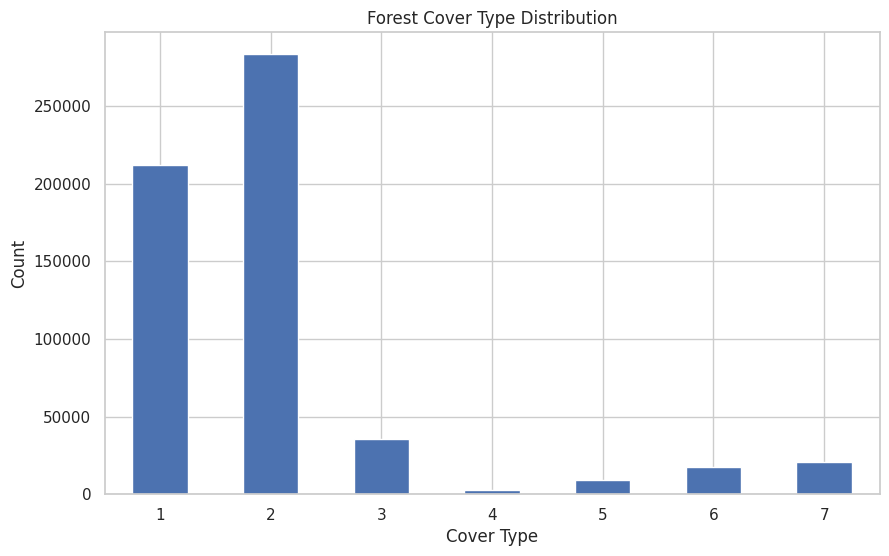

In [8]:
# Target distribution bar plot
plt.figure(figsize=(10, 6))
df['Cover_Type'].value_counts().sort_index().plot(kind='bar')
plt.title('Forest Cover Type Distribution')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

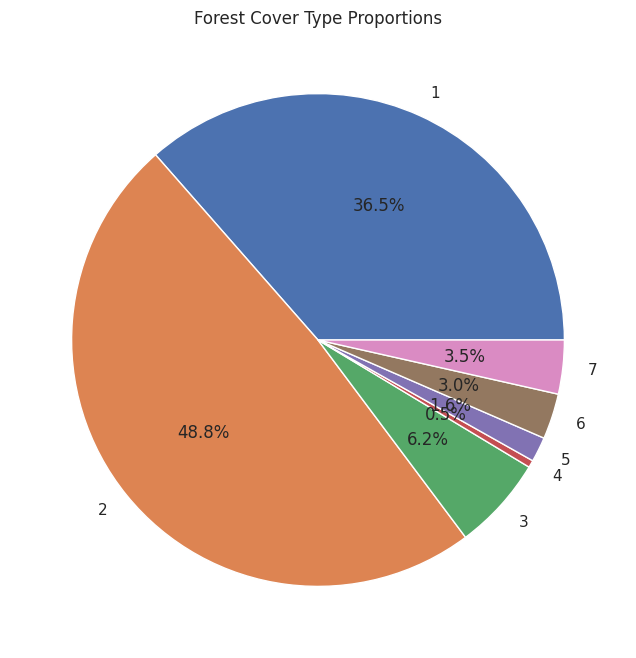

In [10]:
# as pie (for proportions)
plt.figure(figsize=(8, 8))
df['Cover_Type'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%')
plt.title('Forest Cover Type Proportions')
plt.ylabel('')  # Hide y-label for pie
plt.show()

* Models may bias toward majority classes (1 & 2)—expect high overall accuracy but poor recall for rare ones (e.g., 4).
* Action: Stratified split (already done) preserves proportions. We can consider `class_weight='balanced'` in models or oversampling (e.g., SMOTE) for better minority performance.

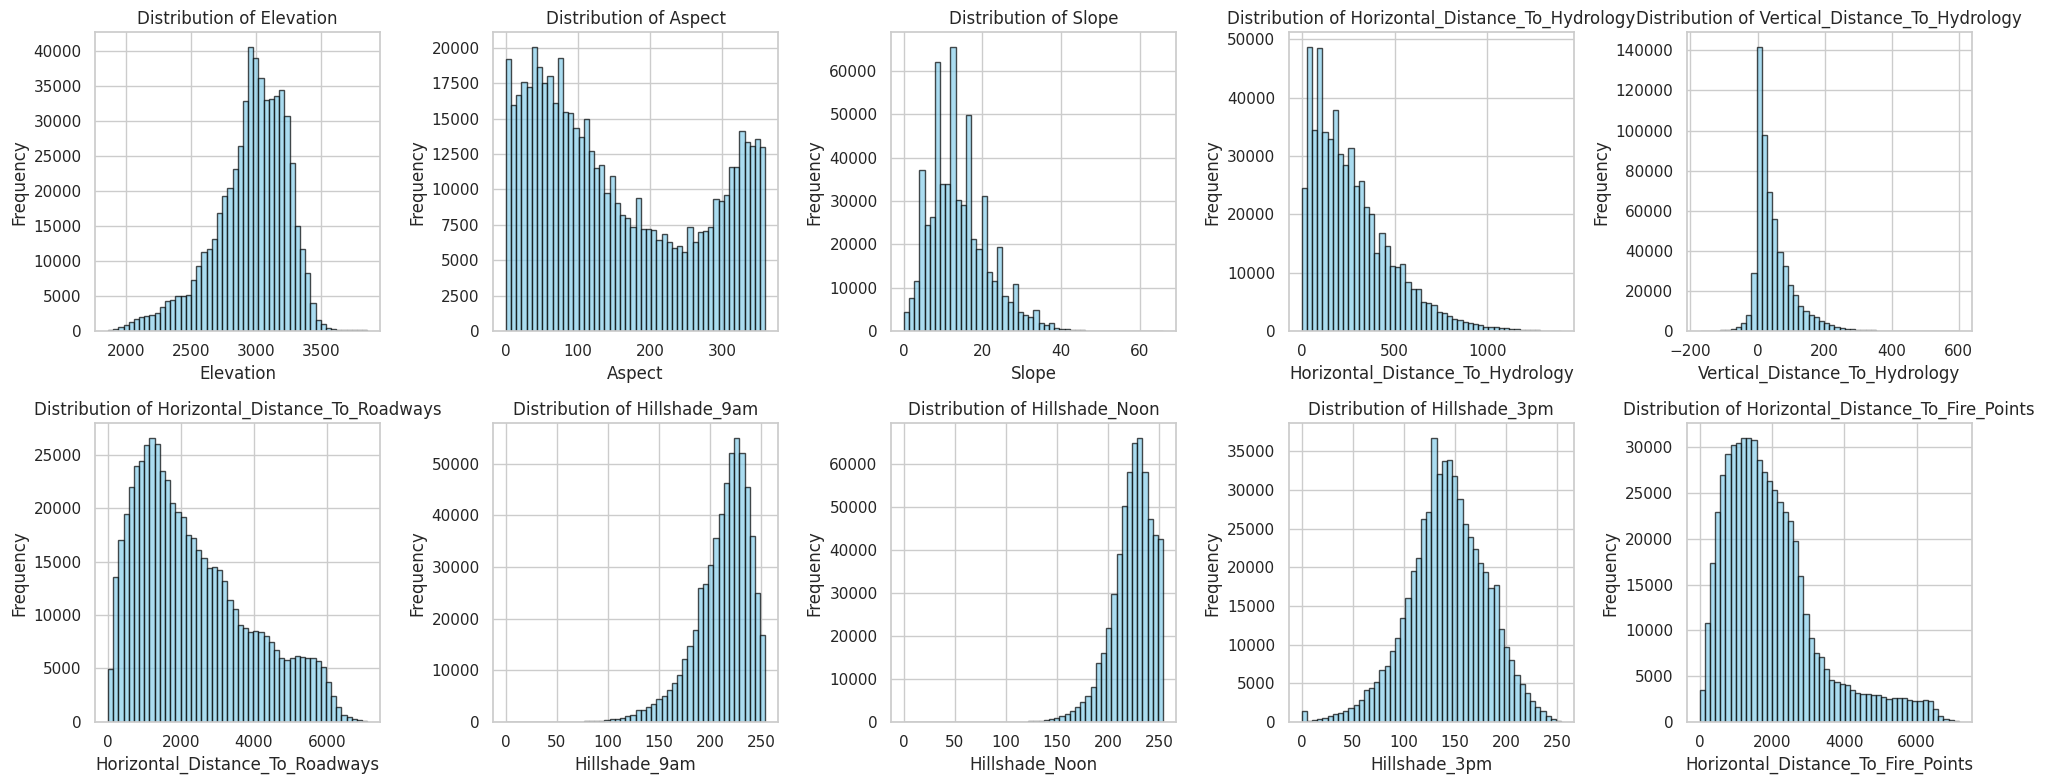

In [11]:
# Select continuous features
cont_features = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]

# Histograms (subplots for all 10)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, feature in enumerate(cont_features):
    axes[idx].hist(df[feature], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

* No extreme outliers or uniforms—data is "natural" for environmental vars. Skewness suggests no log-transform needed for trees (RF/XGB handle it), but could help linear models.
* Action: These vars likely discriminative (e.g., Elevation separates types).

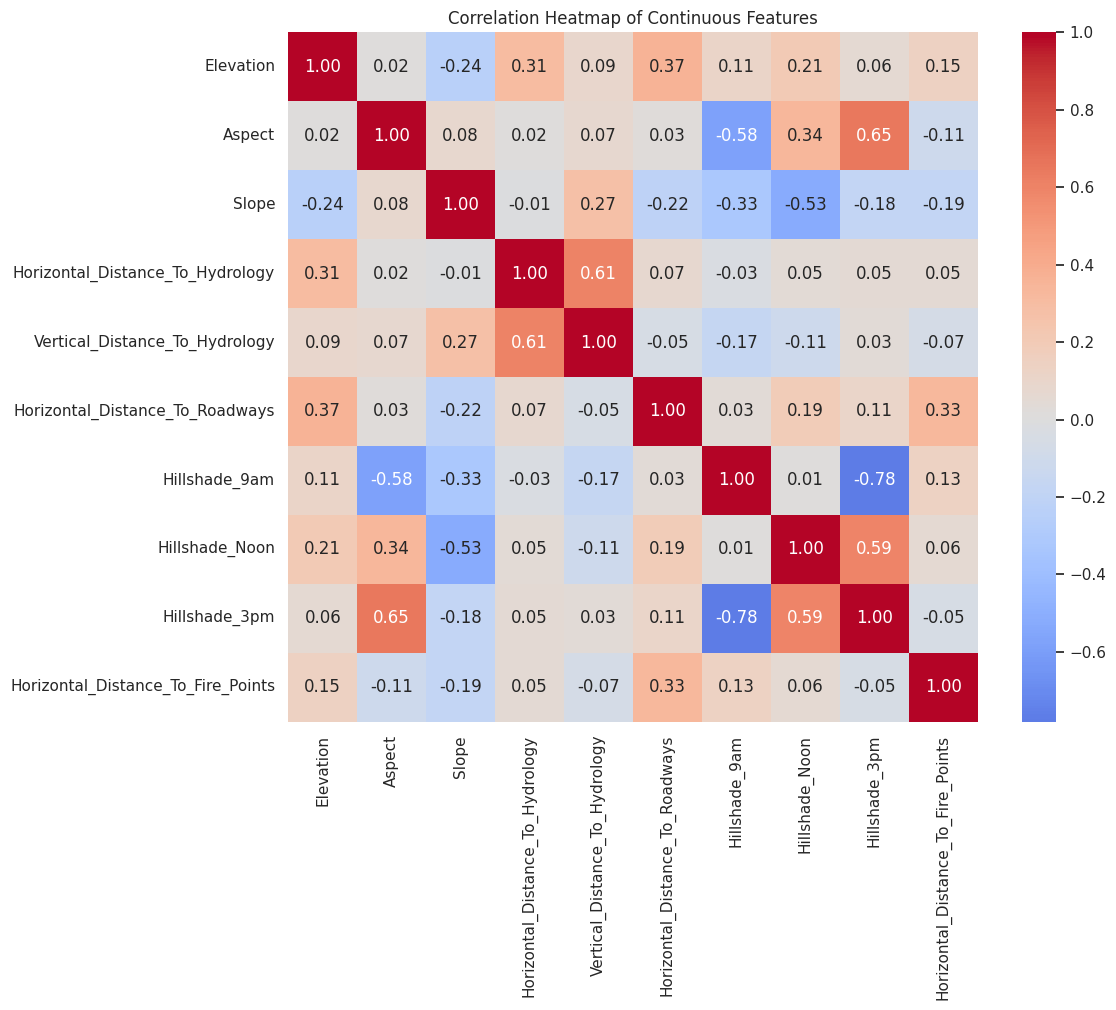

In [12]:
# Correlation matrix for continuous features
corr_matrix = df[cont_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Heatmap of Continuous Features')
plt.tight_layout()
plt.show()

* Mostly low correlations (|r| < 0.5)—no major multicollinearity (e.g., Elevation & Slope: -0.24, mild negative).
* Features are mostly independent—good for model stability (no need to drop cols for redundancy).
* Action: If using linear models, check VIF (variance inflation factor); for us, proceed—no feature engineering needed.


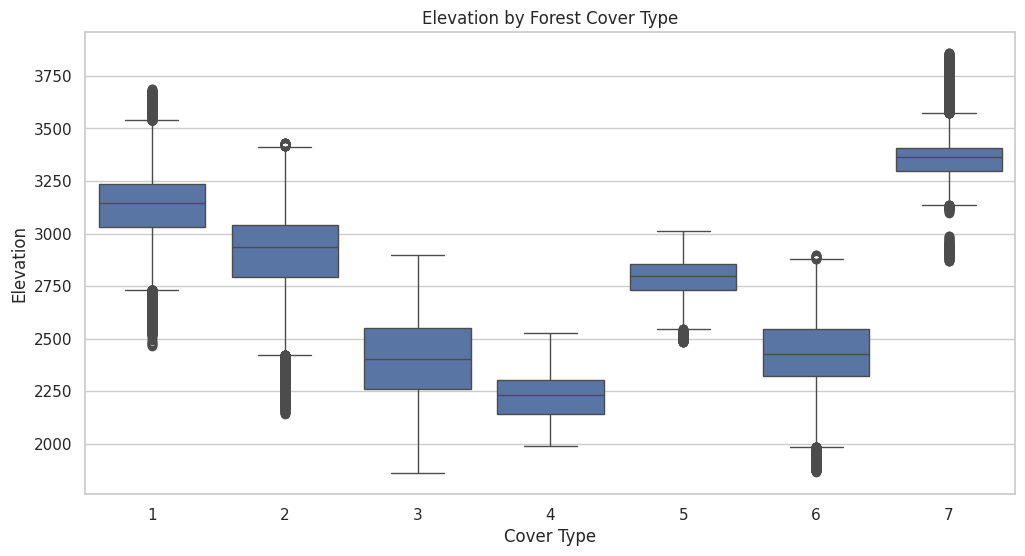

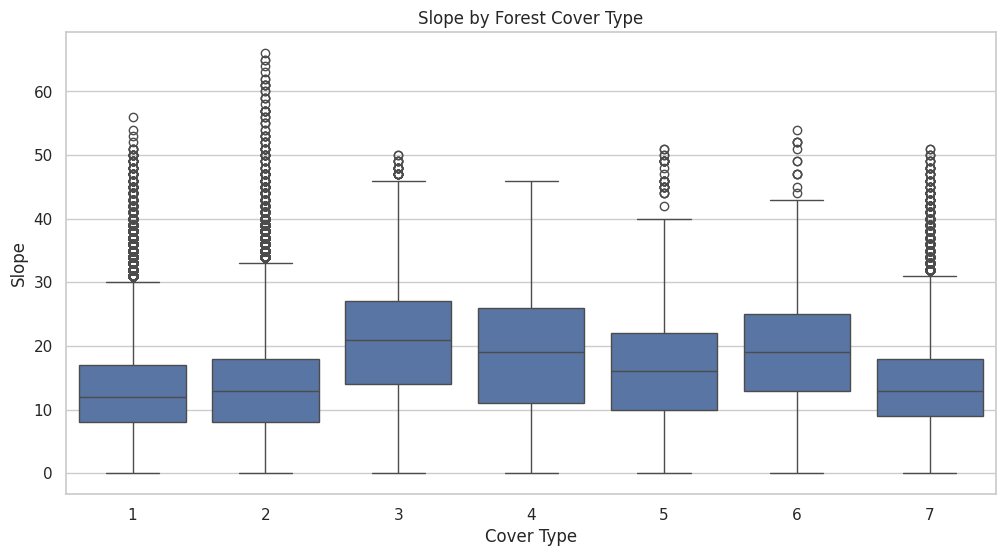

In [13]:
# Boxplot for Elevation across Cover Types
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Cover_Type', y='Elevation')
plt.title('Elevation by Forest Cover Type')
plt.xlabel('Cover Type')
plt.ylabel('Elevation')
plt.show()

# Quick one for Slope (repeat pattern for others)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Cover_Type', y='Slope')
plt.title('Slope by Forest Cover Type')
plt.xlabel('Cover Type')
plt.ylabel('Slope')
plt.show()

* Separability: Elevation strongly differentiates types (e.g., Type 1 = high spruce/fir; Type 2 = lowland lodgepole)—expect it to rank high in importance.
* Outliers: Natural (extreme terrains); no cleaning needed.
* Action: Confirms multi-class challenge—models must learn subtle combos. Binary features (soils/wilderness) will help disambiguate.

In [14]:
# Basic stats table for continuous features
stats = df[cont_features].describe()
print("Continuous Features Summary:")
print(stats.round(2))

Continuous Features Summary:
       Elevation     Aspect      Slope  Horizontal_Distance_To_Hydrology  \
count  581012.00  581012.00  581012.00                         581012.00   
mean     2959.37     155.66      14.10                            269.43   
std       279.98     111.91       7.49                            212.55   
min      1859.00       0.00       0.00                              0.00   
25%      2809.00      58.00       9.00                            108.00   
50%      2996.00     127.00      13.00                            218.00   
75%      3163.00     260.00      18.00                            384.00   
max      3858.00     360.00      66.00                           1397.00   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                       581012.00                        581012.00   
mean                            46.42                          2350.15   
std                             58.30                          1

## **Step 4:** Train Random Forest

In [17]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Random Forest - Train Accuracy: {train_acc_rf:.4f}")
print(f"Random Forest - Test Accuracy: {test_acc_rf:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.1s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.4s


Random Forest - Train Accuracy: 1.0000
Random Forest - Test Accuracy: 0.9533

Classification Report (Test):
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.77      0.85      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.0s finished


**Overall**: Great start—model handles multi-class well, but imbalance hurts rare classes (e.g., Type 4/5). We'll see if XGBoost improves.

## **Step 5:** Train and Evaluate XGBoost

In [21]:
# Shift labels to 0-6 for XGBoost
y_train_shifted = y_train - 1
y_test_shifted = y_test - 1

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', num_class=7, n_estimators=100, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train_shifted)

# Predictions (shift back to 1-7)
y_train_pred_xgb = xgb_model.predict(X_train) + 1
y_test_pred_xgb = xgb_model.predict(X_test) + 1

# Evaluation (use original y for comparison)
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"XGBoost - Train Accuracy: {train_acc_xgb:.4f}")
print(f"XGBoost - Test Accuracy: {test_acc_xgb:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))

XGBoost - Train Accuracy: 0.8791
XGBoost - Test Accuracy: 0.8696

Classification Report (Test):
              precision    recall  f1-score   support

           1       0.86      0.84      0.85     42368
           2       0.87      0.90      0.88     56661
           3       0.89      0.91      0.90      7151
           4       0.88      0.86      0.87       549
           5       0.89      0.61      0.72      1899
           6       0.85      0.80      0.82      3473
           7       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



XG underfits due to regularization.

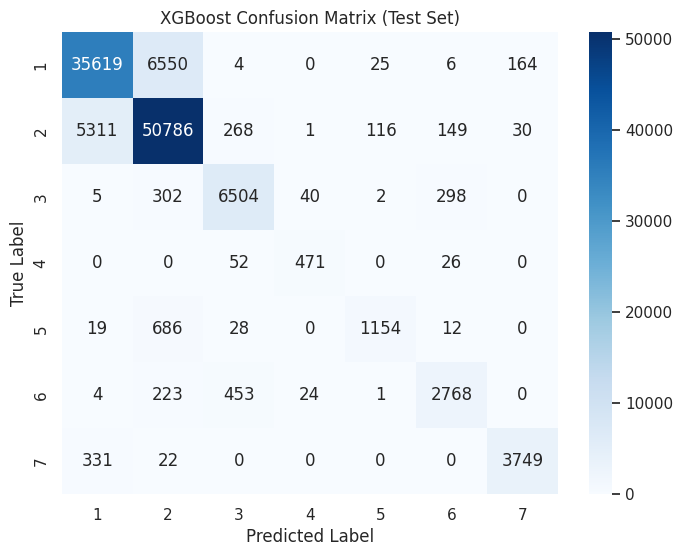

In [22]:
# Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,8), yticklabels=range(1,8))
plt.title('XGBoost Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

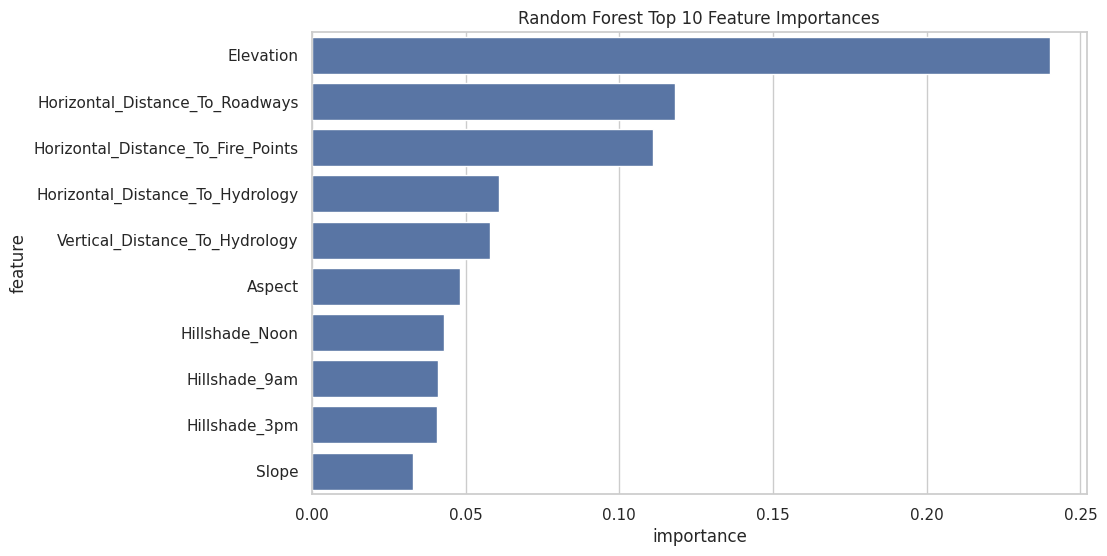

<Figure size 1000x600 with 0 Axes>

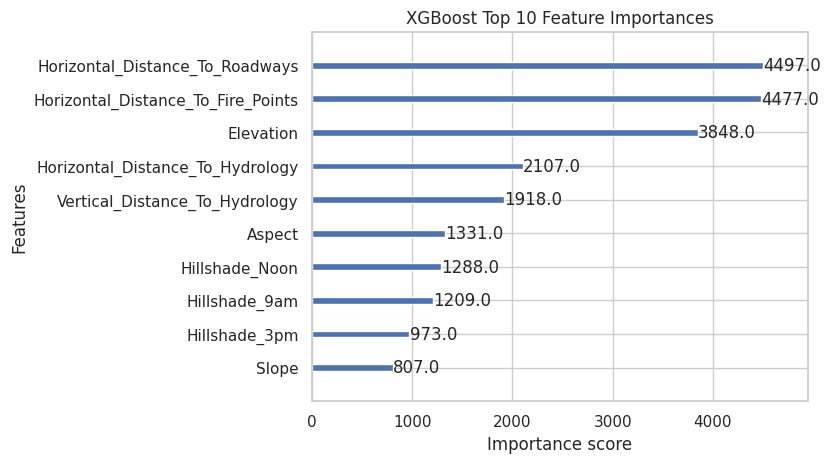

In [23]:
# Random Forest Feature Importance (from earlier)
importances_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_rf, x='importance', y='feature')
plt.title('Random Forest Top 10 Feature Importances')
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title('XGBoost Top 10 Feature Importances')
plt.show()

* **RF (Bagging):** Builds independent trees on bootstraps, averages votes. Handles high-dim (54 feats) via random subspace—reduces variance, excels on separable data like Covertype (low corrs from EDA heatmap). Overfits train (100%) but generalizes via diversity (test 95%).
* **XGBoost (Boosting)**: Sequential trees minimize loss via gradients + regularization. Defaults (learning_rate=0.3, max_depth=6, subsample=1) prune aggressively to avoid overfitting, but here cause underfitting (train 88%)—dataset's size/cleanliness needs less penalty.